## 卷积神经网络 - MNIST数据集分类 ##
参考:
1. Giancarlo Zaccone, Getting Started with TensorFlow, 2016.

### 准备数据和定义模型变量

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib
import matplotlib.pyplot as plt

'''
one_hot：一个长度为n的数组，只有一个元素是1，其他元素是0。
比如为了表示0..9个数字，数字1的one hot编码为[0 1 0 0 0 0 0 0 0 0]
数字9的one hot编码为[0 0 0 0 0 0 0 0 1 0]
'''
mnist = input_data.read_data_sets(r'D:\Code\GitHub\notebook\datasets\mnist', one_hot=True)

Extracting D:\Code\GitHub\notebook\datasets\mnist\train-images-idx3-ubyte.gz
Extracting D:\Code\GitHub\notebook\datasets\mnist\train-labels-idx1-ubyte.gz
Extracting D:\Code\GitHub\notebook\datasets\mnist\t10k-images-idx3-ubyte.gz
Extracting D:\Code\GitHub\notebook\datasets\mnist\t10k-labels-idx1-ubyte.gz


### 了解MNIST数据集 ###

(55000, 784) (55000, 10)
(10000, 784) (10000, 10)
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


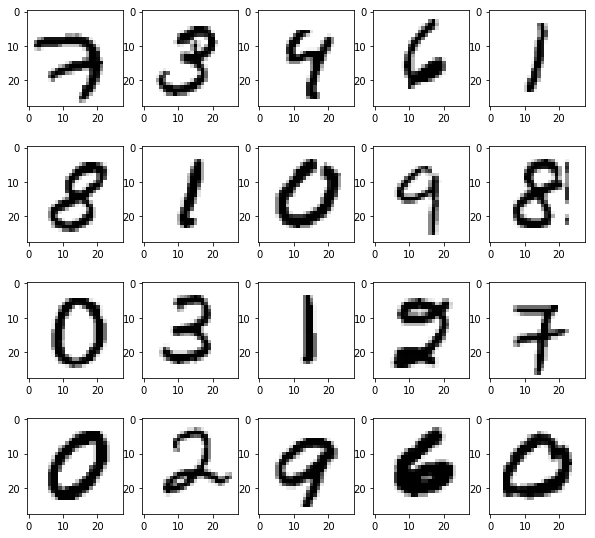

In [2]:
print(mnist.train.images.shape, mnist.train.labels.shape)
print(mnist.test.images.shape, mnist.test.labels.shape)
print(mnist.train.labels[0:20])
fig = plt.figure(figsize=(10,10))
for i in range(20):
    img = mnist.train.images[i]
    img = img.reshape(28, 28)
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap = matplotlib.cm.binary, interpolation="nearest")  
plt.subplots_adjust(hspace=0)
plt.show()

### 初始化 ###

In [3]:
# 学习率
learning_rate = 0.001 
# 训练迭代次数
training_iters = 100000
# 一个训练批次中训练数据的个数。数字越小表示训练过程越接近
batch_size = 100
# 控制输出打印频率
display_step = 20
# 输入层节点数，这里指每个数字的像素个数28*28
n_input = 784
# 输出节点数，这里指MNIST标签个数0..9
n_classes = 10
# dropout是指在深度学习网络的训练过程中，为了避免过拟合，按照一定的概率将一部分神经网络单元从网络中丢弃
dropout = 0.75

# 定义输入图的占位符，并转换为4维张量
x = tf.placeholder(tf.float32, [None,n_input])
# x变成一个4d向量，其第2、第3维对应图片的宽、高，最后一维代表图片的颜色通道数(因为是灰度图所以这里的通道数为1，如果是rgb彩色图，则为3)
_X = tf.reshape(x, shape=[-1,28,28,1])
# 定义输出图的占位符
y_ = tf.placeholder(tf.float32, [None,n_classes])

### 第一卷积层 ###

In [4]:
# 把_X和权值向量进行卷积，加上偏置项，然后应用ReLU激活函数，最后进行max pooling（池化），用下面两个函数完成
# 这里卷积使用1步长（stride size），0边距（padding size）的模板，保证输出和输入是同一个大小。
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w , strides=[1,1,1,1], padding='SAME'), b))

def max_pool(img, k):
    return tf.nn.max_pool(img, ksize=[1,k,k,1], strides=[1,k,k,1], padding='SAME')

# 为了识别每个图形，需要进行特征映射，这里假设有32个特征。
# 卷积的权重张量形状是[5, 5, 1, 32]，前两个维度是patch的大小，接着是输入的通道数目，最后是输出的通道数目，而对于每一个输出通道都有一个对应的偏置量。
wc1 = tf.Variable(tf.truncated_normal([5,5,1,32], stddev=0.1))
bc1 = tf.Variable(tf.constant(0.1, shape=[32]))
# 把_X和权值向量进行卷积，加上偏置项，应用ReLU激活函数，并进行max pooling（池化），经过第一卷积层，图形shape从28*28缩减为14*14
conv1 = conv2d(_X, wc1, bc1)
conv1 = max_pool(conv1, k=2)
# 使用dropout丢弃一定数量的神经元
keep_prob = tf.placeholder(tf.float32)
conv1 = tf.nn.dropout(conv1, keep_prob)

### 第二卷积层 ###

In [5]:
# 对于第二卷积层，假设有64个特征映射
wc2 = tf.Variable(tf.truncated_normal([5,5,32,64], stddev=0.1))
bc2 = tf.Variable(tf.constant(0.1, shape=[64]))
# 同第一卷积层进行卷积、池化和dropout操作，经过第二卷积层，图形shape从14*14缩减为7*7
conv2 = conv2d(conv1, wc2, bc2)
conv2 = max_pool(conv2, k=2)
conv2 = tf.nn.dropout(conv2, keep_prob)

### 全连接层 ###

In [6]:
# 这里加入一个神经元数目为1024的全连接层来处理所有图像。
wd1 = tf.Variable(tf.truncated_normal([7*7*64, 1024], stddev=0.1))
bd1 = tf.Variable(tf.truncated_normal([1024], stddev=0.1))
# 池化层的输出reshape为一个一维向量，与权值相乘，加上偏置通过一个ReLu函数
dense1 = tf.reshape(conv2, [-1,wd1.get_shape().as_list()[0]])
dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, wd1), bd1))
dense1 = tf.nn.dropout(dense1, keep_prob)

### 输出层 ###

In [7]:
wout = tf.Variable(tf.truncated_normal([1024, n_classes], stddev=0.1))
bout = tf.Variable(tf.truncated_normal([n_classes], stddev=0.1))
y = tf.add(tf.matmul(dense1,wout), bout)

### 训练和模型评估 ###

In [8]:
# 成本函数
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))
# 优化模型
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# 测试评估模型
# argmax给出给定张量中在指定轴axis上的最大值的位置（索引）
correct_pred = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
# 计算准确度accuracy，cast函数是类型转换函数，将索引值转换为浮点数
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 运行图
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step*batch_size < training_iters:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={x:batch_xs, y_:batch_ys, keep_prob:dropout})
        if step%display_step == 0:
            acc = sess.run(accuracy, feed_dict={x:batch_xs, y_:batch_ys, keep_prob:1.0})
            loss = sess.run(cost, feed_dict={x:batch_xs, y_:batch_ys, keep_prob:1.0})
            print('Iter'+str(step*batch_size)+', Minibatch Loss= '+'{:.6f}'.format(loss)+', Traning Accuracy= '+'{:.5f}'.format(acc))
        step += 1
    print('Optimization Finished')
    print('Testing Accuracy:', sess.run(accuracy, feed_dict={x: mnist.test.images[:256], y_: mnist.test.labels[:256], keep_prob:1.0}))  

Iter2000, Minibatch Loss= 1.825536, Traning Accuracy= 0.43000
Iter4000, Minibatch Loss= 0.650443, Traning Accuracy= 0.87000
Iter6000, Minibatch Loss= 0.394222, Traning Accuracy= 0.88000
Iter8000, Minibatch Loss= 0.336906, Traning Accuracy= 0.90000
Iter10000, Minibatch Loss= 0.324832, Traning Accuracy= 0.88000
Iter12000, Minibatch Loss= 0.281625, Traning Accuracy= 0.94000
Iter14000, Minibatch Loss= 0.213992, Traning Accuracy= 0.91000
Iter16000, Minibatch Loss= 0.098789, Traning Accuracy= 0.98000
Iter18000, Minibatch Loss= 0.158036, Traning Accuracy= 0.96000
Iter20000, Minibatch Loss= 0.147357, Traning Accuracy= 0.95000
Iter22000, Minibatch Loss= 0.182696, Traning Accuracy= 0.96000
Iter24000, Minibatch Loss= 0.062161, Traning Accuracy= 0.99000
Iter26000, Minibatch Loss= 0.140299, Traning Accuracy= 0.95000
Iter28000, Minibatch Loss= 0.134400, Traning Accuracy= 0.95000
Iter30000, Minibatch Loss= 0.116395, Traning Accuracy= 0.96000
Iter32000, Minibatch Loss= 0.138442, Traning Accuracy= 0.95